# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")
```

env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
print("Brain Name: ", brain_name)
# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print("State sizes: ", states.shape)
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

# main function that sets up environments
# perform training loop

import envs
from buffer import ReplayBuffer
from maddpg import MADDPG
import torch
import numpy as np
from tensorboardX import SummaryWriter
import os
from utilities import transpose_list, transpose_to_tensor

# keep training awake
from workspace_utils import keep_awake

# for saving gif
import imageio

def seeding(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)

def pre_process(entity, batchsize):
    processed_entity = []
    for j in range(3):
        list = []
        for i in range(batchsize):
            b = entity[i][j]
            list.append(b)
        c = torch.Tensor(list)
        processed_entity.append(c)
    return processed_entity


def main():
    seeding()
    # number of parallel agents
    parallel_envs = 4
    # number of training episodes.
    # change this to higher number to experiment. say 30000.
    number_of_episodes = 1000
    episode_length = 80
    batchsize = 1000
    # how many episodes to save policy and gif
    save_interval = 1000
    t = 0
    
    # amplitude of OU noise
    # this slowly decreases to 0
    noise = 2
    noise_reduction = 0.9999

    # how many episodes before update
    episode_per_update = 2 * parallel_envs

    log_path = os.getcwd()+"/log"
    model_dir= os.getcwd()+"/model_dir"
    
    os.makedirs(model_dir, exist_ok=True)

    torch.set_num_threads(parallel_envs)
    env = envs.make_parallel_env(parallel_envs)
    
    # keep 5000 episodes worth of replay
    buffer = ReplayBuffer(int(5000*episode_length))
    
    # initialize policy and critic
    maddpg = MADDPG()
    logger = SummaryWriter(log_dir=log_path)
    agent0_reward = []
    agent1_reward = []
    agent2_reward = []

    # training loop
    # show progressbar
    import progressbar as pb
    widget = ['episode: ', pb.Counter(),'/',str(number_of_episodes),' ', 
              pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ' ]
    
    timer = pb.ProgressBar(widgets=widget, maxval=number_of_episodes).start()

    # use keep_awake to keep workspace from disconnecting
    for episode in keep_awake(range(0, number_of_episodes, parallel_envs)):

        timer.update(episode)


        reward_this_episode = np.zeros((parallel_envs, 3))
        all_obs = env.reset() #
        # obs.shape = env_agent x N_agent x features
        obs, obs_full = transpose_list(all_obs)

        #for calculating rewards for this particular episode - addition of all time steps

        # save info or not
        save_info = ((episode) % save_interval < parallel_envs or episode==number_of_episodes-parallel_envs)
        frames = []
        tmax = 0
        
        if save_info:
            frames.append(env.render('rgb_array'))


        
        for episode_t in range(episode_length):

            t += parallel_envs
            

            # explore = only explore for a certain number of episodes
            # action input needs to be transposed
            actions = maddpg.act(transpose_to_tensor(obs), noise=noise)
            noise *= noise_reduction
            
            actions_array = torch.stack(actions).detach().numpy()

            # transpose the list of list
            # flip the first two indices
            # input to step requires the first index to correspond to number of parallel agents
            actions_for_env = np.rollaxis(actions_array,1)
            
            # step forward one frame
            next_obs, next_obs_full, rewards, dones, info = env.step(actions_for_env)
            
            # add data to buffer
            transition = (obs, obs_full, actions_for_env, rewards, next_obs, next_obs_full, dones)
            
            # Buffer will save [N_agent x features], No. of evn_agent = Number of samples push to buffer at once
            buffer.push(transition)
            
            reward_this_episode += rewards

            obs, obs_full = next_obs, next_obs_full
            
            # save gif frame
            if save_info:
                frames.append(env.render('rgb_array'))
                tmax+=1
        
        # update once after every episode_per_update
        if len(buffer) > batchsize and episode % episode_per_update < parallel_envs:
            for a_i in range(3):
                samples = buffer.sample(batchsize)
                maddpg.update(samples, a_i, logger)
            maddpg.update_targets() #soft update the target network towards the actual networks

        
        
        for i in range(parallel_envs):
            agent0_reward.append(reward_this_episode[i,0])
            agent1_reward.append(reward_this_episode[i,1])
            agent2_reward.append(reward_this_episode[i,2])

        if episode % 100 == 0 or episode == number_of_episodes-1:
            avg_rewards = [np.mean(agent0_reward), np.mean(agent1_reward), np.mean(agent2_reward)]
            agent0_reward = []
            agent1_reward = []
            agent2_reward = []
            for a_i, avg_rew in enumerate(avg_rewards):
                logger.add_scalar('agent%i/mean_episode_rewards' % a_i, avg_rew, episode)

        #saving model
        save_dict_list =[]
        if save_info:
            for i in range(3):

                save_dict = {'actor_params' : maddpg.maddpg_agent[i].actor.state_dict(),
                             'actor_optim_params': maddpg.maddpg_agent[i].actor_optimizer.state_dict(),
                             'critic_params' : maddpg.maddpg_agent[i].critic.state_dict(),
                             'critic_optim_params' : maddpg.maddpg_agent[i].critic_optimizer.state_dict()}
                save_dict_list.append(save_dict)

                torch.save(save_dict_list, 
                           os.path.join(model_dir, 'episode-{}.pt'.format(episode)))
                
            # save gif files
            imageio.mimsave(os.path.join(model_dir, 'episode-{}.gif'.format(episode)), 
                            frames, duration=.04)

    env.close()
    logger.close()
    timer.finish()

if __name__=='__main__':
    main()

### 4.1 Import settings
Initiate the environment

In [1]:
import os
import torch 
import random
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from unityagents import UnityEnvironment
import numpy as np
from maddpg_ import *
# !pip install progressbar2
import progressbar as pb
from torch.utils.tensorboard import SummaryWriter

#---------------Environment set-up--------------------#
env =UnityEnvironment(file_name='Tennis_Linux_NoVis/Tennis.x86_64')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Initiate environment
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]            # get the current state
score = 0

# number of agents in the environment
print('Number of agents:', len(env_info.agents))
# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)
state_size = len(state)
print('States have length:', state_size)
#agent = DDPGAgent(state_size=state_size, action_size=action_size, seed=0)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Number of actions: 2
States have length: 24


ddpg_body_dim = [(256,128),(256,128)]

maddpg = MADDPG(state_size, action_size, ddpg_body_dim=ddpg_body_dim, seed=0, batch_size=128, buffer_size=int(10e5), tau=1e-3,\
                gamma=0.99, decay_noise=0.99,lr_actor=1e-3, lr_critic=1e-3, weight_decay=1e-6, device=device)

In [2]:
def main():
    """
    Multiagent Deep deterministic Policy Gradient (MADDPG)
    This specific MMADDPG will learn how to play a game of tennis. There are 24 states-observables and 2 action-dimensions for
    each agent. 
        
    """
    # ---------------Configuration----------------#
    # Episodes and Trajectory
    n_episodes = 5000
    trajectory_length = 50
    batch_size = 256
    
    # Model Parameters
    ddpg_body_dim = [(400,256),(400,256)]
    seed = 0
    buffer_size = int(1e5)
    tau = 3e-2
    gamma = 0.99
    decay_noise = 0.99
    lr_actor = 1e-4
    lr_critic = 5e-4
    weight_decay = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    print("Device used: ", device)
    maddpg = MADDPG(state_size, action_size, ddpg_body_dim=ddpg_body_dim, seed=seed,\
                    batch_size=batch_size, buffer_size=buffer_size, tau=tau, gamma=gamma,\
                    decay_noise=decay_noise,lr_actor=lr_actor, lr_critic=lr_critic,\
                    weight_decay=weight_decay, device=device)
    
    # Save configurations
    log_path = os.getcwd()+"/log"
    model_dir= os.getcwd()+"/model_dir"
    os.makedirs(model_dir, exist_ok=True)
    
    # initialize logging of rewards
    logger = SummaryWriter(log_dir=log_path)
    agent0_reward = []
    agent0_window = deque(maxlen=100)
    agent1_reward = []
    agent1_window = deque(maxlen=100)
    avg_rewards = 0
    avg_rewards_window = 0
    scores =[]
    scores_100 = []
    

    
    
    widget = ["Training Status: ", pb.Timer(), ' ', pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar()]
    #timer = pb.progressbar(widgets=widget, maxval=n_episodes).start()
    
    ##############################################################################
    #---------------------------Training Commence--------------------------------#
    for i_episode in pb.progressbar(range(1, n_episodes+1), widgets=widget):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations           # get the current state
        score = np.zeros(len(env_info.agents))
        for t in range(trajectory_length):
        
            actions = maddpg.acts(states, noise=1.0)  # state[n_agent,dim], noise=1.0 (on)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations   # get the next state: array -  (num_agent, state_feature_dim)
            rewards = env_info.rewards                   # get the reward: list - [num_agent]
            dones = env_info.local_done                  # see if episode has finished: list - [num_agent]
            
            # Add to memory
        
            maddpg.memory.add_experience(states,actions,rewards, next_states,dones)
            
            score += rewards                               # update the score
            states = next_states                             # roll over the state to next time step
            if (np.any(dones) and t>40):
                break
            
            
            if len(maddpg.memory) > batch_size:
                for agent_i in range(2):
                    experiences = maddpg.memory.sample(batch_size)
                    maddpg.step(experiences, agent_i, logger)
                maddpg.update_targets()
        # Update once after every episode
        maddpg.tau*=0.99                   # Reduce the learning of soft-update
           
        agent0_reward.append(score[0])       # save latest score into a variable containing the 100 latest scores
        agent0_window.append(score[0])     # save latest score
        agent1_reward.append(score[1])
        agent1_window.append(score[1])
        scores.append(score)
        

        if i_episode % 100 ==0 or i_episode==n_episodes-1:
            avg_rewards = [np.mean(agent0_reward), np.mean(agent1_reward)]
            scores_100.append(avg_rewards)
            avg_rewards_window = [np.mean(agent0_window), np.mean(agent1_window)]
            agent0_reward = []
            agent1_reward = []
            for agent_i , (avg_reward, avg_reward_window) in enumerate(zip(avg_rewards, avg_rewards_window)):
                logger.add_scalar("Agent%i/mean_episode_rewards"% agent_i, avg_reward, avg_reward_window, i_episode)
            
        if i_episode % 20 == 0:
            print('\rEpisode {}\tScore: {}\t 100 Moving Average Score: {}, OUNOISE: {}'.format(i_episode, score, avg_rewards_window, maddpg.maddpg_agent[0].noise.state*maddpg.maddpg_agent[0].decay_noise))
            
        # save model
        agent_checkpoints = []
        if np.mean(avg_rewards_window)>=0.5 and i_episode >=100:
            
            print('\nEnvironment solved in {:d} episodes!\t Score: {:5.2f}\t 10 Moving Average Score: {:.2f}'.format(i_episode, avg_rewards, avg_rewards_window))
            for agent_i in range(2):
                checkpoint = {
                    'net_params': maddpg.maddpg_agent[agent_i].network_local.state_dict()}   
                agent_checkpoints.append(checkpoint)
            print("\nModel saved!💎🙌")
            torch.save(agent_checkpoints, model_dir+'checkpoint.pt')
    logger.close()
    
    return (scores, scores_100, maddpg)
if __name__=="__main__":
    main()
output_tuple = main()

Device used:  cuda:0


Training Status: Elapsed Time: 0:01:49   1% ETA:   2:30:43 |                  |

Episode 60	Score: [-0.02 -0.01]	 100 Moving Average Score: 0, OUNOISE: [0.28864218 0.30873187]


Training Status: Elapsed Time: 0:02:28   1% ETA:   2:32:26 |                  |

Episode 80	Score: [-0.02 -0.01]	 100 Moving Average Score: 0, OUNOISE: [0.30042531 0.25025185]


Training Status: Elapsed Time: 0:03:08   2% ETA:   2:33:33 |                  |

Episode 100	Score: [-0.02 -0.02]	 100 Moving Average Score: [-0.010899999681860208, -0.01469999959692359], OUNOISE: [0.19366186 0.20008498]


Training Status: Elapsed Time: 0:03:48   2% ETA:   2:34:38 |                  |

Episode 120	Score: [0.08 0.  ]	 100 Moving Average Score: [-0.010899999681860208, -0.01469999959692359], OUNOISE: [0.15216405 0.15138821]


Training Status: Elapsed Time: 0:04:28   2% ETA:   2:35:22 |                  |

Episode 140	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.010899999681860208, -0.01469999959692359], OUNOISE: [0.11653457 0.11787663]


Training Status: Elapsed Time: 0:05:08   3% ETA:   2:35:39 |                  |

Episode 160	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.010899999681860208, -0.01469999959692359], OUNOISE: [0.1131653  0.09743027]


Training Status: Elapsed Time: 0:05:47   3% ETA:   2:35:12 |                  |

Episode 180	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.010899999681860208, -0.01469999959692359], OUNOISE: [0.05891498 0.07536682]


Training Status: Elapsed Time: 0:06:27   4% ETA:   2:34:55 |                  |

Episode 200	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.0021999995410442352, -0.014699999634176493], OUNOISE: [0.05059894 0.06304059]


Training Status: Elapsed Time: 0:07:08   4% ETA:   2:35:07 |                  |

Episode 220	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.0021999995410442352, -0.014699999634176493], OUNOISE: [0.03693388 0.04067067]


Training Status: Elapsed Time: 0:07:48   4% ETA:   2:34:56 |                  |

Episode 240	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.0021999995410442352, -0.014699999634176493], OUNOISE: [0.02664461 0.0305639 ]


Training Status: Elapsed Time: 0:08:31   5% ETA:   2:35:20 |                  |

Episode 260	Score: [ 0.   -0.02]	 100 Moving Average Score: [-0.0021999995410442352, -0.014699999634176493], OUNOISE: [0.02084759 0.02027321]


Training Status: Elapsed Time: 0:09:13   5% ETA:   2:35:29 |#                 |

Episode 280	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.0021999995410442352, -0.014699999634176493], OUNOISE: [0.01265458 0.02031213]


Training Status: Elapsed Time: 0:09:56   6% ETA:   2:35:45 |#                 |

Episode 300	Score: [-0.01  0.08]	 100 Moving Average Score: [0.017300000637769698, 0.0018000006303191185], OUNOISE: [0.01589918 0.01258061]


Training Status: Elapsed Time: 0:10:40   6% ETA:   2:36:02 |#                 |

Episode 320	Score: [-0.01  0.09]	 100 Moving Average Score: [0.017300000637769698, 0.0018000006303191185], OUNOISE: [0.01346508 0.00903297]


Training Status: Elapsed Time: 0:11:23   6% ETA:   2:36:01 |#                 |

Episode 340	Score: [ 0.2  -0.02]	 100 Moving Average Score: [0.017300000637769698, 0.0018000006303191185], OUNOISE: [0.00591016 0.00909073]


Training Status: Elapsed Time: 0:12:03   7% ETA:   2:35:27 |#                 |

Episode 360	Score: [-0.01 -0.02]	 100 Moving Average Score: [0.017300000637769698, 0.0018000006303191185], OUNOISE: [0.00400504 0.00433164]


Training Status: Elapsed Time: 0:12:47   7% ETA:   2:35:28 |#                 |

Episode 380	Score: [-0.03 -0.01]	 100 Moving Average Score: [0.017300000637769698, 0.0018000006303191185], OUNOISE: [0.00454266 0.00446988]


Training Status: Elapsed Time: 0:13:30   8% ETA:   2:35:23 |#                 |

Episode 400	Score: [ 0.   -0.03]	 100 Moving Average Score: [0.039100000876933334, -0.005699999462813139], OUNOISE: [0.00351458 0.00349262]


Training Status: Elapsed Time: 0:14:12   8% ETA:   2:34:51 |#                 |

Episode 420	Score: [-0.01 -0.02]	 100 Moving Average Score: [0.039100000876933334, -0.005699999462813139], OUNOISE: [0.00195476 0.00307053]


Training Status: Elapsed Time: 0:14:52   8% ETA:   2:34:07 |#                 |

Episode 440	Score: [ 0.   -0.03]	 100 Moving Average Score: [0.039100000876933334, -0.005699999462813139], OUNOISE: [0.00196672 0.00161317]


Training Status: Elapsed Time: 0:15:33   9% ETA:   2:33:35 |#                 |

Episode 460	Score: [-0.02 -0.01]	 100 Moving Average Score: [0.039100000876933334, -0.005699999462813139], OUNOISE: [0.00150078 0.00130893]


Training Status: Elapsed Time: 0:16:17   9% ETA:   2:33:26 |#                 |

Episode 480	Score: [ 0.19000001 -0.01      ]	 100 Moving Average Score: [0.039100000876933334, -0.005699999462813139], OUNOISE: [0.00116378 0.00110837]


Training Status: Elapsed Time: 0:17:01  10% ETA:   2:33:13 |#                 |

Episode 500	Score: [-0.02 -0.01]	 100 Moving Average Score: [0.028800000846385957, 0.0029000006057322025], OUNOISE: [0.00087268 0.00066436]


Training Status: Elapsed Time: 0:17:42  10% ETA:   2:32:30 |#                 |

Episode 520	Score: [-0.03  0.  ]	 100 Moving Average Score: [0.028800000846385957, 0.0029000006057322025], OUNOISE: [0.00047394 0.00062452]


Training Status: Elapsed Time: 0:18:25  10% ETA:   2:32:10 |#                 |

Episode 540	Score: [-0.01  0.09]	 100 Moving Average Score: [0.028800000846385957, 0.0029000006057322025], OUNOISE: [0.00044521 0.00037216]


Training Status: Elapsed Time: 0:19:09  11% ETA:   2:31:50 |##                |

Episode 560	Score: [ 0.1  -0.02]	 100 Moving Average Score: [0.028800000846385957, 0.0029000006057322025], OUNOISE: [0.00037321 0.00034205]


Training Status: Elapsed Time: 0:19:50  11% ETA:   2:31:13 |##                |

Episode 580	Score: [-0.02 -0.01]	 100 Moving Average Score: [0.028800000846385957, 0.0029000006057322025], OUNOISE: [0.0002616  0.00021024]


Training Status: Elapsed Time: 0:20:32  12% ETA:   2:30:40 |##                |

Episode 600	Score: [-0.03 -0.01]	 100 Moving Average Score: [0.018600000627338888, -0.007499999441206455], OUNOISE: [0.00020024 0.00023765]


Training Status: Elapsed Time: 0:21:14  12% ETA:   2:30:06 |##                |

Episode 620	Score: [-0.01 -0.02]	 100 Moving Average Score: [0.018600000627338888, -0.007499999441206455], OUNOISE: [0.0001704  0.00015775]


Training Status: Elapsed Time: 0:21:58  12% ETA:   2:29:39 |##                |

Episode 640	Score: [ 0.1  -0.03]	 100 Moving Average Score: [0.018600000627338888, -0.007499999441206455], OUNOISE: [7.79838035e-05 1.10763449e-04]


Training Status: Elapsed Time: 0:22:39  13% ETA:   2:28:59 |##                |

Episode 660	Score: [-0.01 -0.01]	 100 Moving Average Score: [0.018600000627338888, -0.007499999441206455], OUNOISE: [8.79820396e-05 5.86138049e-05]


Training Status: Elapsed Time: 0:23:20  13% ETA:   2:28:16 |##                |

Episode 680	Score: [-0.02 -0.01]	 100 Moving Average Score: [0.018600000627338888, -0.007499999441206455], OUNOISE: [6.21139072e-05 6.86189449e-05]


Training Status: Elapsed Time: 0:24:02  14% ETA:   2:27:38 |##                |

Episode 700	Score: [-0.01 -0.02]	 100 Moving Average Score: [0.008600000590085984, -0.014399999640882016], OUNOISE: [4.96175543e-05 5.28158666e-05]


Training Status: Elapsed Time: 0:24:42  14% ETA:   2:26:50 |##                |

Episode 720	Score: [-0.02 -0.01]	 100 Moving Average Score: [0.008600000590085984, -0.014399999640882016], OUNOISE: [2.80520040e-05 3.81698956e-05]


Training Status: Elapsed Time: 0:25:22  14% ETA:   2:26:04 |##                |

Episode 740	Score: [-0.03  0.  ]	 100 Moving Average Score: [0.008600000590085984, -0.014399999640882016], OUNOISE: [3.17761225e-05 2.25234477e-05]


Training Status: Elapsed Time: 0:26:02  15% ETA:   2:25:16 |##                |

Episode 760	Score: [-0.02 -0.01]	 100 Moving Average Score: [0.008600000590085984, -0.014399999640882016], OUNOISE: [2.89136413e-05 2.26944722e-05]


Training Status: Elapsed Time: 0:26:43  15% ETA:   2:24:34 |##                |

Episode 780	Score: [ 0.   -0.03]	 100 Moving Average Score: [0.008600000590085984, -0.014399999640882016], OUNOISE: [1.71179013e-05 2.09059865e-05]


Training Status: Elapsed Time: 0:27:25  16% ETA:   2:23:59 |##                |

Episode 800	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.012899999655783177, -0.014899999629706144], OUNOISE: [1.10495602e-05 9.26459729e-06]


Training Status: Elapsed Time: 0:28:06  16% ETA:   2:23:19 |##                |

Episode 820	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.012899999655783177, -0.014899999629706144], OUNOISE: [9.27219183e-06 1.34464398e-05]


Training Status: Elapsed Time: 0:28:48  16% ETA:   2:22:38 |###               |

Episode 840	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.012899999655783177, -0.014899999629706144], OUNOISE: [5.56556189e-06 6.78132455e-06]


Training Status: Elapsed Time: 0:29:28  17% ETA:   2:21:53 |###               |

Episode 860	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.012899999655783177, -0.014899999629706144], OUNOISE: [7.14104364e-06 4.62102960e-06]


Training Status: Elapsed Time: 0:30:08  17% ETA:   2:21:07 |###               |

Episode 880	Score: [-0.03  0.  ]	 100 Moving Average Score: [-0.012899999655783177, -0.014899999629706144], OUNOISE: [3.92051202e-06 4.33186850e-06]


Training Status: Elapsed Time: 0:30:48  18% ETA:   2:20:20 |###               |

Episode 900	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.012699999678879977, -0.015499999653548003], OUNOISE: [3.14876584e-06 3.30520039e-06]


Training Status: Elapsed Time: 0:31:28  18% ETA:   2:19:34 |###               |

Episode 920	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.012699999678879977, -0.015499999653548003], OUNOISE: [2.97597704e-06 2.71000000e-06]


Training Status: Elapsed Time: 0:32:08  18% ETA:   2:18:48 |###               |

Episode 940	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.012699999678879977, -0.015499999653548003], OUNOISE: [2.36623322e-06 2.25116681e-06]


Training Status: Elapsed Time: 0:32:48  19% ETA:   2:18:03 |###               |

Episode 960	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.012699999678879977, -0.015499999653548003], OUNOISE: [1.71228498e-06 1.85592690e-06]


Training Status: Elapsed Time: 0:33:32  19% ETA:   2:17:36 |###               |

Episode 980	Score: [-0.01 -0.01]	 100 Moving Average Score: [-0.012699999678879977, -0.015499999653548003], OUNOISE: [1.01423031e-06 1.29137664e-06]


Training Status: Elapsed Time: 0:34:13  20% ETA:   2:16:54 |###               |

Episode 1000	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.015999999642372132, -0.013599999696016312], OUNOISE: [1.27475610e-06 1.00804576e-06]


Training Status: Elapsed Time: 0:34:53  20% ETA:   2:16:08 |###               |

Episode 1020	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.015999999642372132, -0.013599999696016312], OUNOISE: [6.15680674e-07 9.31830193e-07]


Training Status: Elapsed Time: 0:35:33  20% ETA:   2:15:23 |###               |

Episode 1040	Score: [ 0.   -0.03]	 100 Moving Average Score: [-0.015999999642372132, -0.013599999696016312], OUNOISE: [6.79494217e-07 6.30558394e-07]


Training Status: Elapsed Time: 0:36:15  21% ETA:   2:14:46 |###               |

Episode 1060	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.015999999642372132, -0.013599999696016312], OUNOISE: [4.30115151e-07 4.51318874e-07]


Training Status: Elapsed Time: 0:36:56  21% ETA:   2:14:05 |###               |

Episode 1080	Score: [-0.03  0.  ]	 100 Moving Average Score: [-0.015999999642372132, -0.013599999696016312], OUNOISE: [2.56789302e-07 3.18803024e-07]


Training Status: Elapsed Time: 0:37:38  22% ETA:   2:13:26 |###               |

Episode 1100	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.011299999672919512, -0.016399999633431434], OUNOISE: [2.00511335e-07 2.68364587e-07]


Training Status: Elapsed Time: 0:38:19  22% ETA:   2:12:46 |####              |

Episode 1120	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.011299999672919512, -0.016399999633431434], OUNOISE: [1.79098933e-07 1.44207680e-07]


Training Status: Elapsed Time: 0:39:00  22% ETA:   2:12:04 |####              |

Episode 1140	Score: [-0.03  0.  ]	 100 Moving Average Score: [-0.011299999672919512, -0.016399999633431434], OUNOISE: [1.86478934e-07 1.21230586e-07]


Training Status: Elapsed Time: 0:39:41  23% ETA:   2:11:22 |####              |

Episode 1160	Score: [ 0.   -0.03]	 100 Moving Average Score: [-0.011299999672919512, -0.016399999633431434], OUNOISE: [1.13506642e-07 1.30369431e-07]


Training Status: Elapsed Time: 0:40:21  23% ETA:   2:10:37 |####              |

Episode 1180	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.011299999672919512, -0.016399999633431434], OUNOISE: [9.41826613e-08 6.35873165e-08]


Training Status: Elapsed Time: 0:41:03  24% ETA:   2:10:00 |####              |

Episode 1200	Score: [ 0.   -0.02]	 100 Moving Average Score: [-0.011299999672919512, -0.01629999963566661], OUNOISE: [9.54815983e-08 5.27562376e-08]


Training Status: Elapsed Time: 0:41:44  24% ETA:   2:09:21 |####              |

Episode 1220	Score: [-0.03  0.  ]	 100 Moving Average Score: [-0.011299999672919512, -0.01629999963566661], OUNOISE: [4.80693544e-08 5.61544364e-08]


Training Status: Elapsed Time: 0:42:23  24% ETA:   2:08:33 |####              |

Episode 1240	Score: [-0.03  0.  ]	 100 Moving Average Score: [-0.011299999672919512, -0.01629999963566661], OUNOISE: [4.56074157e-08 4.10802049e-08]


Training Status: Elapsed Time: 0:43:04  25% ETA:   2:07:51 |####              |

Episode 1260	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.011299999672919512, -0.01629999963566661], OUNOISE: [2.59186161e-08 3.10828492e-08]


Training Status: Elapsed Time: 0:43:43  25% ETA:   2:07:04 |####              |

Episode 1280	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.011299999672919512, -0.01629999963566661], OUNOISE: [2.74622979e-08 2.69753193e-08]


Training Status: Elapsed Time: 0:44:24  26% ETA:   2:06:23 |####              |

Episode 1300	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.01339999970048666, -0.01669999962672591], OUNOISE: [1.76756489e-08 2.75566257e-08]


Training Status: Elapsed Time: 0:45:04  26% ETA:   2:05:40 |####              |

Episode 1320	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.01339999970048666, -0.01669999962672591], OUNOISE: [1.45325847e-08 1.31987411e-08]


Training Status: Elapsed Time: 0:45:44  26% ETA:   2:04:56 |####              |

Episode 1340	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.01339999970048666, -0.01669999962672591], OUNOISE: [1.19859361e-08 8.76703508e-09]


Training Status: Elapsed Time: 0:46:25  27% ETA:   2:04:15 |####              |

Episode 1360	Score: [ 0.09 -0.01]	 100 Moving Average Score: [-0.01339999970048666, -0.01669999962672591], OUNOISE: [8.65909777e-09 8.57606984e-09]


Training Status: Elapsed Time: 0:47:07  27% ETA:   2:03:36 |####              |

Episode 1380	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.01339999970048666, -0.01669999962672591], OUNOISE: [7.15743654e-09 5.59505487e-09]


Training Status: Elapsed Time: 0:47:47  28% ETA:   2:02:54 |#####             |

Episode 1400	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.00929999964311719, -0.015999999642372132], OUNOISE: [4.78155797e-09 4.37704969e-09]


Training Status: Elapsed Time: 0:48:29  28% ETA:   2:02:15 |#####             |

Episode 1420	Score: [-0.02  0.  ]	 100 Moving Average Score: [-0.00929999964311719, -0.015999999642372132], OUNOISE: [4.81621063e-09 3.79801116e-09]


Training Status: Elapsed Time: 0:49:09  28% ETA:   2:01:30 |#####             |

Episode 1440	Score: [ 0.   -0.03]	 100 Moving Average Score: [-0.00929999964311719, -0.015999999642372132], OUNOISE: [2.78384022e-09 3.21672351e-09]


Training Status: Elapsed Time: 0:49:51  29% ETA:   2:00:53 |#####             |

Episode 1460	Score: [ 0.1  -0.02]	 100 Moving Average Score: [-0.00929999964311719, -0.015999999642372132], OUNOISE: [3.01850204e-09 2.93973136e-09]


Training Status: Elapsed Time: 0:50:33  29% ETA:   2:00:14 |#####             |

Episode 1480	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.00929999964311719, -0.015999999642372132], OUNOISE: [1.63734312e-09 1.29215714e-09]


Training Status: Elapsed Time: 0:51:13  30% ETA:   1:59:31 |#####             |

Episode 1500	Score: [-0.02 -0.01]	 100 Moving Average Score: [0.003900000508874655, -0.015099999625235797], OUNOISE: [1.29640674e-09 1.40581329e-09]


Training Status: Elapsed Time: 0:51:55  30% ETA:   1:58:53 |#####             |

Episode 1520	Score: [-0.01 -0.02]	 100 Moving Average Score: [0.003900000508874655, -0.015099999625235797], OUNOISE: [1.46127733e-09 1.02736797e-09]


Training Status: Elapsed Time: 0:52:36  30% ETA:   1:58:11 |#####             |

Episode 1540	Score: [-0.01 -0.02]	 100 Moving Average Score: [0.003900000508874655, -0.015099999625235797], OUNOISE: [9.46421957e-10 4.44031494e-10]


Training Status: Elapsed Time: 0:53:16  31% ETA:   1:57:28 |#####             |

Episode 1560	Score: [-0.02 -0.01]	 100 Moving Average Score: [0.003900000508874655, -0.015099999625235797], OUNOISE: [7.13355098e-10 7.56563976e-10]


Training Status: Elapsed Time: 0:53:57  31% ETA:   1:56:48 |#####             |

Episode 1580	Score: [ 0.1  -0.01]	 100 Moving Average Score: [0.003900000508874655, -0.015099999625235797], OUNOISE: [5.76178981e-10 4.82551878e-10]


Training Status: Elapsed Time: 0:54:40  32% ETA:   1:56:10 |#####             |

Episode 1600	Score: [ 0.08 -0.02]	 100 Moving Average Score: [0.008500000610947609, -0.015399999655783177], OUNOISE: [4.40457674e-10 4.56816408e-10]


Training Status: Elapsed Time: 0:55:20  32% ETA:   1:55:27 |#####             |

Episode 1620	Score: [-0.01 -0.02]	 100 Moving Average Score: [0.008500000610947609, -0.015399999655783177], OUNOISE: [3.64187057e-10 3.23924677e-10]


Training Status: Elapsed Time: 0:56:03  32% ETA:   1:54:51 |#####             |

Episode 1640	Score: [ 0.1  -0.02]	 100 Moving Average Score: [0.008500000610947609, -0.015399999655783177], OUNOISE: [2.09143679e-10 2.00679896e-10]


Training Status: Elapsed Time: 0:56:48  33% ETA:   1:54:17 |#####             |

Episode 1660	Score: [-0.02 -0.01]	 100 Moving Average Score: [0.008500000610947609, -0.015399999655783177], OUNOISE: [1.86289423e-10 1.81148491e-10]


Training Status: Elapsed Time: 0:57:30  33% ETA:   1:53:38 |######            |

Episode 1680	Score: [ 0.09 -0.02]	 100 Moving Average Score: [0.008500000610947609, -0.015399999655783177], OUNOISE: [1.18867160e-10 8.62971429e-11]


Training Status: Elapsed Time: 0:58:14  34% ETA:   1:53:03 |######            |

Episode 1700	Score: [ 0.1  -0.02]	 100 Moving Average Score: [0.02710000079125166, -0.015899999644607306], OUNOISE: [8.09329729e-11 1.08027094e-10]


Training Status: Elapsed Time: 0:58:55  34% ETA:   1:52:22 |######            |

Episode 1720	Score: [-0.02 -0.01]	 100 Moving Average Score: [0.02710000079125166, -0.015899999644607306], OUNOISE: [5.32804517e-11 6.49589689e-11]


Training Status: Elapsed Time: 0:59:38  34% ETA:   1:51:43 |######            |

Episode 1740	Score: [ 0.   -0.03]	 100 Moving Average Score: [0.02710000079125166, -0.015899999644607306], OUNOISE: [7.49837762e-11 5.50504543e-11]


Training Status: Elapsed Time: 1:00:20  35% ETA:   1:51:05 |######            |

Episode 1760	Score: [ 0.1  -0.01]	 100 Moving Average Score: [0.02710000079125166, -0.015899999644607306], OUNOISE: [4.63447096e-11 4.13086404e-11]


Training Status: Elapsed Time: 1:01:03  35% ETA:   1:50:27 |######            |

Episode 1780	Score: [-0.01 -0.02]	 100 Moving Average Score: [0.02710000079125166, -0.015899999644607306], OUNOISE: [1.94757066e-11 3.86266006e-11]


Training Status: Elapsed Time: 1:01:48  36% ETA:   1:49:52 |######            |

Episode 1800	Score: [-0.03  0.  ]	 100 Moving Average Score: [0.04340000091120601, -0.01739999957382679], OUNOISE: [2.66882969e-11 2.83427034e-11]


Training Status: Elapsed Time: 1:02:32  36% ETA:   1:49:16 |######            |

Episode 1820	Score: [-0.01 -0.02]	 100 Moving Average Score: [0.04340000091120601, -0.01739999957382679], OUNOISE: [1.71062570e-11 1.86822289e-11]


Training Status: Elapsed Time: 1:03:18  36% ETA:   1:48:43 |######            |

Episode 1840	Score: [ 0.1  -0.01]	 100 Moving Average Score: [0.04340000091120601, -0.01739999957382679], OUNOISE: [1.18496510e-11 1.74971887e-11]


Training Status: Elapsed Time: 1:04:03  37% ETA:   1:48:09 |######            |

Episode 1860	Score: [ 0.   -0.02]	 100 Moving Average Score: [0.04340000091120601, -0.01739999957382679], OUNOISE: [1.10945566e-11 8.62604702e-12]


Training Status: Elapsed Time: 1:04:48  37% ETA:   1:47:33 |######            |

Episode 1880	Score: [ 0.1  -0.01]	 100 Moving Average Score: [0.04340000091120601, -0.01739999957382679], OUNOISE: [6.23869404e-12 8.77192281e-12]


Training Status: Elapsed Time: 1:05:32  38% ETA:   1:46:56 |######            |

Episode 1900	Score: [ 0.09 -0.01]	 100 Moving Average Score: [0.07120000116527081, -0.017199999615550042], OUNOISE: [6.58188541e-12 7.14440948e-12]


Training Status: Elapsed Time: 1:06:15  38% ETA:   1:46:16 |######            |

Episode 1920	Score: [-0.03  0.  ]	 100 Moving Average Score: [0.07120000116527081, -0.017199999615550042], OUNOISE: [5.05693230e-12 2.24965025e-12]


Training Status: Elapsed Time: 1:07:00  38% ETA:   1:45:41 |######            |

Episode 1940	Score: [ 0.09 -0.01]	 100 Moving Average Score: [0.07120000116527081, -0.017199999615550042], OUNOISE: [3.32976667e-12 3.14124358e-12]


Training Status: Elapsed Time: 1:07:42  39% ETA:   1:45:01 |#######           |

Episode 1960	Score: [-0.02 -0.02]	 100 Moving Average Score: [0.07120000116527081, -0.017199999615550042], OUNOISE: [1.72675578e-12 2.05211043e-12]


Training Status: Elapsed Time: 1:08:25  39% ETA:   1:44:22 |#######           |

Episode 1980	Score: [ 0.   -0.03]	 100 Moving Average Score: [0.07120000116527081, -0.017199999615550042], OUNOISE: [1.58360546e-12 2.33703562e-12]


Training Status: Elapsed Time: 1:09:06  40% ETA:   1:43:39 |#######           |

Episode 2000	Score: [-0.03  0.  ]	 100 Moving Average Score: [0.007700000572949648, -0.015399999655783177], OUNOISE: [1.27090855e-12 1.42151671e-12]


Training Status: Elapsed Time: 1:09:47  40% ETA:   1:42:57 |#######           |

Episode 2020	Score: [-0.01 -0.02]	 100 Moving Average Score: [0.007700000572949648, -0.015399999655783177], OUNOISE: [9.89466770e-13 1.10294994e-12]


Training Status: Elapsed Time: 1:10:28  40% ETA:   1:42:14 |#######           |

Episode 2040	Score: [-0.02 -0.01]	 100 Moving Average Score: [0.007700000572949648, -0.015399999655783177], OUNOISE: [1.04148106e-12 7.12008780e-13]


Training Status: Elapsed Time: 1:11:09  41% ETA:   1:41:32 |#######           |

Episode 2060	Score: [-0.01 -0.02]	 100 Moving Average Score: [0.007700000572949648, -0.015399999655783177], OUNOISE: [7.14543780e-13 6.71111464e-13]


Training Status: Elapsed Time: 1:11:50  41% ETA:   1:40:50 |#######           |

Episode 2080	Score: [ 0.   -0.03]	 100 Moving Average Score: [0.007700000572949648, -0.015399999655783177], OUNOISE: [5.83789433e-13 6.09387634e-13]


Training Status: Elapsed Time: 1:12:31  42% ETA:   1:40:09 |#######           |

Episode 2100	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.016099999640136958, -0.013799999691545963], OUNOISE: [3.42969718e-13 2.81488211e-13]


Training Status: Elapsed Time: 1:13:14  42% ETA:   1:39:29 |#######           |

Episode 2120	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.016099999640136958, -0.013799999691545963], OUNOISE: [2.45612189e-13 2.94326840e-13]


Training Status: Elapsed Time: 1:13:57  42% ETA:   1:38:50 |#######           |

Episode 2140	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.016099999640136958, -0.013799999691545963], OUNOISE: [2.85062012e-13 2.10777632e-13]


Training Status: Elapsed Time: 1:14:39  43% ETA:   1:38:09 |#######           |

Episode 2160	Score: [ 0.   -0.03]	 100 Moving Average Score: [-0.016099999640136958, -0.013799999691545963], OUNOISE: [1.84568732e-13 2.00745220e-13]


Training Status: Elapsed Time: 1:15:22  43% ETA:   1:37:29 |#######           |

Episode 2180	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.016099999640136958, -0.013799999691545963], OUNOISE: [1.87086089e-13 1.35078491e-13]


Training Status: Elapsed Time: 1:16:04  44% ETA:   1:36:48 |#######           |

Episode 2200	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.014899999666959048, -0.014899999666959048], OUNOISE: [1.46285465e-13 1.36712106e-13]


Training Status: Elapsed Time: 1:16:45  44% ETA:   1:36:07 |#######           |

Episode 2220	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.014899999666959048, -0.014899999666959048], OUNOISE: [8.76673619e-14 7.08374931e-14]


Training Status: Elapsed Time: 1:17:26  44% ETA:   1:35:25 |########          |

Episode 2240	Score: [ 0.   -0.03]	 100 Moving Average Score: [-0.014899999666959048, -0.014899999666959048], OUNOISE: [7.12786272e-14 8.20001449e-14]


Training Status: Elapsed Time: 1:18:08  45% ETA:   1:34:44 |########          |

Episode 2260	Score: [-0.03  0.  ]	 100 Moving Average Score: [-0.014899999666959048, -0.014899999666959048], OUNOISE: [6.69315790e-14 5.56056266e-14]


Training Status: Elapsed Time: 1:18:51  45% ETA:   1:34:05 |########          |

Episode 2280	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.014899999666959048, -0.014899999666959048], OUNOISE: [3.05766787e-14 4.35116020e-14]


Training Status: Elapsed Time: 1:19:35  46% ETA:   1:33:26 |########          |

Episode 2300	Score: [ 0.   -0.03]	 100 Moving Average Score: [-0.014199999682605267, -0.01579999964684248], OUNOISE: [3.15204766e-14 3.23407978e-14]


Training Status: Elapsed Time: 1:20:18  46% ETA:   1:32:45 |########          |

Episode 2320	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.014199999682605267, -0.01579999964684248], OUNOISE: [2.05600403e-14 2.89246127e-14]


Training Status: Elapsed Time: 1:21:01  46% ETA:   1:32:05 |########          |

Episode 2340	Score: [-0.03  0.  ]	 100 Moving Average Score: [-0.014199999682605267, -0.01579999964684248], OUNOISE: [1.77751463e-14 2.14393877e-14]


Training Status: Elapsed Time: 1:21:42  47% ETA:   1:31:24 |########          |

Episode 2360	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.014199999682605267, -0.01579999964684248], OUNOISE: [1.85224471e-14 1.79754102e-14]


Training Status: Elapsed Time: 1:22:25  47% ETA:   1:30:43 |########          |

Episode 2380	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.014199999682605267, -0.01579999964684248], OUNOISE: [8.58097791e-15 1.16439917e-14]


Training Status: Elapsed Time: 1:23:07  48% ETA:   1:30:02 |########          |

Episode 2400	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.015499999653548003, -0.014499999675899744], OUNOISE: [8.00084203e-15 8.53597681e-15]


Training Status: Elapsed Time: 1:23:49  48% ETA:   1:29:21 |########          |

Episode 2420	Score: [ 0.   -0.03]	 100 Moving Average Score: [-0.015499999653548003, -0.014499999675899744], OUNOISE: [6.74176505e-15 8.76042818e-15]


Training Status: Elapsed Time: 1:24:30  48% ETA:   1:28:40 |########          |

Episode 2440	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.015499999653548003, -0.014499999675899744], OUNOISE: [4.79206893e-15 5.14918984e-15]


Training Status: Elapsed Time: 1:25:12  49% ETA:   1:27:58 |########          |

Episode 2460	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.015499999653548003, -0.014499999675899744], OUNOISE: [4.70448639e-15 4.80942873e-15]


Training Status: Elapsed Time: 1:25:55  49% ETA:   1:27:18 |########          |

Episode 2480	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.015499999653548003, -0.014499999675899744], OUNOISE: [1.95624266e-15 3.30774827e-15]


Training Status: Elapsed Time: 1:26:37  50% ETA:   1:26:37 |#########         |

Episode 2500	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.015199999660253524, -0.014799999669194222], OUNOISE: [2.43994093e-15 2.19279435e-15]


Training Status: Elapsed Time: 1:27:18  50% ETA:   1:25:55 |#########         |

Episode 2520	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.015199999660253524, -0.014799999669194222], OUNOISE: [1.74780503e-15 2.24246146e-15]


Training Status: Elapsed Time: 1:28:00  50% ETA:   1:25:13 |#########         |

Episode 2540	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.015199999660253524, -0.014799999669194222], OUNOISE: [1.41984335e-15 1.65228663e-15]


Training Status: Elapsed Time: 1:28:41  51% ETA:   1:24:31 |#########         |

Episode 2560	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.015199999660253524, -0.014799999669194222], OUNOISE: [1.19832981e-15 6.86853732e-16]


Training Status: Elapsed Time: 1:29:22  51% ETA:   1:23:49 |#########         |

Episode 2580	Score: [ 0.   -0.03]	 100 Moving Average Score: [-0.015199999660253524, -0.014799999669194222], OUNOISE: [6.90811415e-16 1.14093753e-15]


Training Status: Elapsed Time: 1:30:03  52% ETA:   1:23:08 |#########         |

Episode 2600	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.013999999649822712, -0.014999999664723873], OUNOISE: [6.05646312e-16 5.97168335e-16]


Training Status: Elapsed Time: 1:30:47  52% ETA:   1:22:28 |#########         |

Episode 2620	Score: [ 0.2  -0.02]	 100 Moving Average Score: [-0.013999999649822712, -0.014999999664723873], OUNOISE: [5.38386667e-16 7.26141365e-16]


Training Status: Elapsed Time: 1:31:31  52% ETA:   1:21:48 |#########         |

Episode 2640	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.013999999649822712, -0.014999999664723873], OUNOISE: [5.39215537e-16 3.52933624e-16]


Training Status: Elapsed Time: 1:32:15  53% ETA:   1:21:09 |#########         |

Episode 2660	Score: [ 0.   -0.03]	 100 Moving Average Score: [-0.013999999649822712, -0.014999999664723873], OUNOISE: [3.19931564e-16 3.34943883e-16]


Training Status: Elapsed Time: 1:32:59  53% ETA:   1:20:30 |#########         |

Episode 2680	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.013999999649822712, -0.014999999664723873], OUNOISE: [3.43822657e-16 2.18010460e-16]


Training Status: Elapsed Time: 1:33:43  54% ETA:   1:19:50 |#########         |

Episode 2700	Score: [ 0.1  -0.01]	 100 Moving Average Score: [0.04060000095516443, -0.020399999544024466], OUNOISE: [1.71951278e-16 1.34641768e-16]


Training Status: Elapsed Time: 1:34:29  54% ETA:   1:19:12 |#########         |

Episode 2720	Score: [ 0.   -0.03]	 100 Moving Average Score: [0.04060000095516443, -0.020399999544024466], OUNOISE: [1.39008357e-16 1.24493999e-16]


Training Status: Elapsed Time: 1:35:16  54% ETA:   1:18:34 |#########         |

Episode 2740	Score: [ 0.1  -0.03]	 100 Moving Average Score: [0.04060000095516443, -0.020399999544024466], OUNOISE: [8.12073335e-17 9.22293852e-17]


Training Status: Elapsed Time: 1:36:01  55% ETA:   1:17:56 |#########         |

Episode 2760	Score: [-0.01 -0.02]	 100 Moving Average Score: [0.04060000095516443, -0.020399999544024466], OUNOISE: [8.11707988e-17 9.70192830e-17]


Training Status: Elapsed Time: 1:36:44  55% ETA:   1:17:15 |##########        |

Episode 2780	Score: [ 0.   -0.03]	 100 Moving Average Score: [0.04060000095516443, -0.020399999544024466], OUNOISE: [7.43032315e-17 5.78526269e-17]


Training Status: Elapsed Time: 1:37:25  56% ETA:   1:16:32 |##########        |

Episode 2800	Score: [-0.02 -0.01]	 100 Moving Average Score: [0.055200001019984485, -0.020399999544024466], OUNOISE: [3.40176080e-17 3.91774625e-17]


Training Status: Elapsed Time: 1:38:06  56% ETA:   1:15:50 |##########        |

Episode 2820	Score: [-0.01 -0.02]	 100 Moving Average Score: [0.055200001019984485, -0.020399999544024466], OUNOISE: [3.58527102e-17 2.57012328e-17]


Training Status: Elapsed Time: 1:38:46  56% ETA:   1:15:07 |##########        |

Episode 2840	Score: [-0.03  0.  ]	 100 Moving Average Score: [0.055200001019984485, -0.020399999544024466], OUNOISE: [3.14561192e-17 3.06075716e-17]


Training Status: Elapsed Time: 1:39:27  57% ETA:   1:14:24 |##########        |

Episode 2860	Score: [-0.02 -0.01]	 100 Moving Average Score: [0.055200001019984485, -0.020399999544024466], OUNOISE: [2.95074179e-17 2.46272969e-17]


Training Status: Elapsed Time: 1:40:07  57% ETA:   1:13:42 |##########        |

Episode 2880	Score: [-0.03  0.  ]	 100 Moving Average Score: [0.055200001019984485, -0.020399999544024466], OUNOISE: [1.64895528e-17 1.82041184e-17]


Training Status: Elapsed Time: 1:40:48  58% ETA:   1:12:59 |##########        |

Episode 2900	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.014899999666959048, -0.015099999662488699], OUNOISE: [1.48910478e-17 1.34466036e-17]


Training Status: Elapsed Time: 1:41:00  58% ETA:   1:12:47 |##########        |IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training Status: Elapsed Time: 2:40:03  91% ETA:   0:14:40 |################  |

Episode 4580	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.014799999669194222, -0.015199999660253524], OUNOISE: [2.49225721e-27 2.52208422e-27]


Training Status: Elapsed Time: 2:40:44  92% ETA:   0:13:58 |################  |

Episode 4600	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.015599999651312828, -0.014399999678134918], OUNOISE: [1.57779467e-27 1.11220024e-27]


Training Status: Elapsed Time: 2:41:25  92% ETA:   0:13:16 |################  |

Episode 4620	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.015599999651312828, -0.014399999678134918], OUNOISE: [1.01243316e-27 1.58264432e-27]


Training Status: Elapsed Time: 2:42:06  92% ETA:   0:12:34 |################  |

Episode 4640	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.015599999651312828, -0.014399999678134918], OUNOISE: [1.10253894e-27 1.04599812e-27]


Training Status: Elapsed Time: 2:42:47  93% ETA:   0:11:52 |################  |

Episode 4660	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.015599999651312828, -0.014399999678134918], OUNOISE: [8.30071987e-28 8.41723595e-28]


Training Status: Elapsed Time: 2:43:28  93% ETA:   0:11:10 |################  |

Episode 4680	Score: [-0.03  0.  ]	 100 Moving Average Score: [-0.015599999651312828, -0.014399999678134918], OUNOISE: [5.89315869e-28 3.84757375e-28]


Training Status: Elapsed Time: 2:44:09  94% ETA:   0:10:28 |################  |

Episode 4700	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.015199999660253524, -0.014799999669194222], OUNOISE: [4.91298158e-28 5.20078581e-28]


Training Status: Elapsed Time: 2:44:51  94% ETA:   0:09:46 |################  |

Episode 4720	Score: [ 0.   -0.03]	 100 Moving Average Score: [-0.015199999660253524, -0.014799999669194222], OUNOISE: [5.12042581e-28 4.02176218e-28]


Training Status: Elapsed Time: 2:45:32  94% ETA:   0:09:04 |################# |

Episode 4740	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.015199999660253524, -0.014799999669194222], OUNOISE: [2.60918333e-28 3.09036428e-28]


Training Status: Elapsed Time: 2:46:13  95% ETA:   0:08:22 |################# |

Episode 4760	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.015199999660253524, -0.014799999669194222], OUNOISE: [2.12771126e-28 2.38113962e-28]


Training Status: Elapsed Time: 2:46:54  95% ETA:   0:07:40 |################# |

Episode 4780	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.015199999660253524, -0.014799999669194222], OUNOISE: [1.58669880e-28 2.41033573e-28]


Training Status: Elapsed Time: 2:47:35  96% ETA:   0:06:58 |################# |

Episode 4800	Score: [-0.03  0.  ]	 100 Moving Average Score: [-0.014799999669194222, -0.015199999660253524], OUNOISE: [1.32534107e-28 1.32871958e-28]


Training Status: Elapsed Time: 2:48:16  96% ETA:   0:06:17 |################# |

Episode 4820	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.014799999669194222, -0.015199999660253524], OUNOISE: [1.00311646e-28 9.86582655e-29]


Training Status: Elapsed Time: 2:48:57  96% ETA:   0:05:35 |################# |

Episode 4840	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.014799999669194222, -0.015199999660253524], OUNOISE: [7.43953281e-29 8.59044649e-29]


Training Status: Elapsed Time: 2:49:39  97% ETA:   0:04:53 |################# |

Episode 4860	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.014799999669194222, -0.015199999660253524], OUNOISE: [5.31395169e-29 6.15200294e-29]


Training Status: Elapsed Time: 2:50:20  97% ETA:   0:04:11 |################# |

Episode 4880	Score: [ 0.   -0.03]	 100 Moving Average Score: [-0.014799999669194222, -0.015199999660253524], OUNOISE: [4.73422415e-29 4.62418812e-29]


Training Status: Elapsed Time: 2:51:01  98% ETA:   0:03:29 |################# |

Episode 4900	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.014899999666959048, -0.015099999662488699], OUNOISE: [3.87124348e-29 3.40599945e-29]


Training Status: Elapsed Time: 2:51:43  98% ETA:   0:02:47 |################# |

Episode 4920	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.014899999666959048, -0.015099999662488699], OUNOISE: [2.61396492e-29 2.65757449e-29]


Training Status: Elapsed Time: 2:52:24  98% ETA:   0:02:05 |################# |

Episode 4940	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.014899999666959048, -0.015099999662488699], OUNOISE: [2.46710138e-29 2.08749680e-29]


Training Status: Elapsed Time: 2:53:05  99% ETA:   0:01:23 |################# |

Episode 4960	Score: [-0.01 -0.02]	 100 Moving Average Score: [-0.014899999666959048, -0.015099999662488699], OUNOISE: [1.17784975e-29 1.50831191e-29]


Training Status: Elapsed Time: 2:53:47  99% ETA:   0:00:41 |################# |

Episode 4980	Score: [-0.02 -0.01]	 100 Moving Average Score: [-0.014899999666959048, -0.015099999662488699], OUNOISE: [1.12700517e-29 1.05627504e-29]


Training Status: Elapsed Time: 2:54:28 100% Time:  2:54:28 |##################|


Episode 5000	Score: [ 0.   -0.03]	 100 Moving Average Score: [-0.015199999660253524, -0.014799999669194222], OUNOISE: [8.89751894e-30 7.29848464e-30]


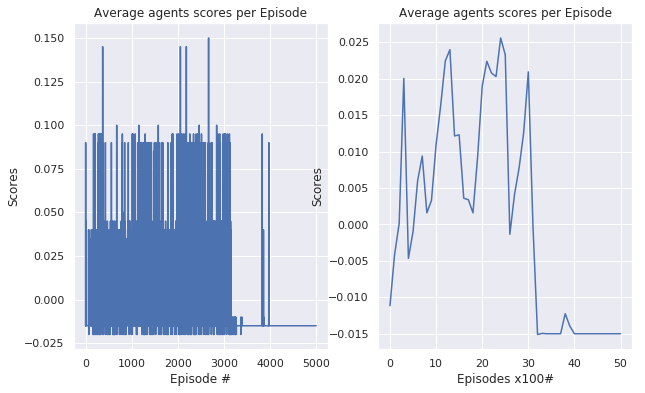

In [3]:
# plot the scores
import seaborn as sns
scores_20, score_20, _  = output_tuple
sns.set()
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(121)
ax1.plot(np.arange(len(scores_20)), np.mean(scores_20, axis=1))
ax2 = fig.add_subplot(122)
ax2.plot(np.arange(len(score_20)), np.mean(score_20, axis=1))

ax1.set(ylabel='Scores', xlabel='Episode #', title="Average agents scores per Episode")
ax2.set(ylabel='Scores', xlabel='Episodes x100#', title="Average agents scores per Episode")
plt.show()
fig.tight_layout()
fig.savefig("/home/lew/Projects/Continuous-control_/plots/20agents-DDPG_reacher.png")

In [4]:
scores_20

[array([-0.02, -0.01]),
 array([0.09, 0.09]),
 array([-0.02, -0.01]),
 array([-0.01, -0.02]),
 array([ 0.1 , -0.01]),
 array([ 0.09, -0.02]),
 array([-0.01, -0.02]),
 array([-0.01, -0.02]),
 array([-0.01, -0.02]),
 array([-0.03,  0.  ]),
 array([ 0.  , -0.03]),
 array([-0.02, -0.01]),
 array([-0.01, -0.02]),
 array([-0.02, -0.01]),
 array([ 0.  , -0.03]),
 array([ 0.  , -0.03]),
 array([-0.02, -0.01]),
 array([-0.02, -0.01]),
 array([-0.01, -0.02]),
 array([-0.01, -0.02]),
 array([-0.01, -0.02]),
 array([-0.01, -0.02]),
 array([-0.02, -0.01]),
 array([-0.01, -0.02]),
 array([-0.02, -0.01]),
 array([-0.02, -0.01]),
 array([-0.02, -0.01]),
 array([-0.01, -0.02]),
 array([-0.02, -0.01]),
 array([-0.03,  0.  ]),
 array([-0.03,  0.  ]),
 array([ 0.  , -0.03]),
 array([-0.02, -0.01]),
 array([-0.01, -0.02]),
 array([-0.03,  0.  ]),
 array([-0.01, -0.02]),
 array([-0.01, -0.02]),
 array([-0.02, -0.01]),
 array([-0.02, -0.01]),
 array([-0.01, -0.02]),
 array([-0.02, -0.01]),
 array([-0.02, -0.